In [44]:
# Import libraries and setup
import networkx as nx     
import numpy as np
import random
import io
import os
import re
import math
import urllib2
import urllib
import json
import codecs
import community
import pickle
import operator
import nltk
from scipy.interpolate import interp1d
from nltk.book import *
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

# Part I: Comunity Structure
**We start by looking at the community structure of the the philosopher network. The community detection methods run on an undirected version of the philosopher graph, so create one of those. If your network has more than one component, just work on the giant connected component (GCC).**

In [2]:
# Load philosophers network and related variables
with open('philosophers_net.pkl') as f:  
    PG,phil_dict,all_phil = pickle.load(f)

# Create and plot undirected version of the graph
PG_undir = PG.to_undirected()

# Detect and choose the Giant Connected Component (GCC) of the network
graphs = list(nx.connected_component_subgraphs(PG_undir))
graph_sizes = [len(graph.nodes()) for graph in graphs]
index = max(enumerate(graph_sizes), key=operator.itemgetter(1))
PG_undir = graphs[index[0]]

**We begin by using the concept of modularity to explore how community-like the six branches of philosophy are.**

* **Explain the concept of modularity in your own words**

<span style="color:blue"> *Modularity is a measure used in networks to detect divisions with a high number of connections or links in a way that the nodes belonging to that division can be considered a community.* </span>

* **Now, calculate the modularity of the branches reported by the Wikipedia editors. Modularity is described in the Network Science book, section 9.4). Use equation 9.12 in the book to calculate the modularity $M$ of the branches-partitioning. **


 * **Hints regarding how to make this happen.**
  * **Firstly, modularity does not work when the communities are overlapping. Thus, we need to do something about the philosophers that are part of multiple branches. We will handle it by creating a set of six new branches, where we take all of the philosophers that belong to more than one branch and assign them to the branch that they have the most connections to.**
* **Now that we have a new set of non-overlapping branches, we can calculate the modularity**

In [3]:
# Given a philospher and a list of branches, this functions calculates in which branch from the list 
# the philosopher has more connections
def branch_counter(branches, philosopher):
    branch_counter = {}
    for branch in branches:
        branch_counter[branch] = 0
        for phil in PG_undir.neighbors(philosopher):
            if phil in phil_dict[branch]:
                branch_counter[branch] += 1
    return max(branch_counter, key=branch_counter.get)

In [4]:
# Create a new set of six branches where each philosopher appears at most once (remove community overlapping)
phil_no_overlap = {'aestheticians':[],'epistemologists':[],'ethicists':[],'logicians':[],
                   'metaphysicians':[],'sociopolitical':[]}

for phil in PG_undir.nodes():
    incidences = []
    for branch in phil_dict.keys():
        if phil in phil_dict[branch]:
            incidences.append(branch)
    
    if len(incidences) == 1:
        phil_no_overlap[incidences[0]].append(phil)
    else:
        phil_no_overlap[branch_counter(incidences,phil)].append(phil)

In [5]:
# Create separate network for each branch
comm_graph = {'aestheticians':nx.Graph(),'epistemologists':nx.Graph(),'ethicists':nx.Graph(),'logicians':nx.Graph(),
                   'metaphysicians':nx.Graph(),'sociopolitical':nx.Graph()}

for graph in comm_graph:
    comm_graph[graph] = PG_undir.subgraph(phil_no_overlap[graph])

In [6]:
# Calculate modularity using the equation 9.12
M = 0
L = len(PG_undir.edges())
for graph in comm_graph:
    Lc = len(comm_graph[graph].edges())
    Kc = sum(PG_undir.degree(comm_graph[graph].nodes()).values())
    Mc = (Lc/L)-pow(Kc/2/L,2)
    M += Mc
print "The modularity found using the equation is %f" %M

The modularity found using the formula is 0.297996


* **Comment on your value of $M$ for the branches. Are the branches good communities? (We will explore this question in depth below.)**

<span style="color:blue"> *The positive value of M reflects a good modularity which means that the branches represent a good good community division* </span>

* **Now, let us use the Python Louvain-algorithm implementation to find communities in the full philosopher network. [Note: This algorithm is available as Anaconda package. Install with conda as expained here].**

**Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?**

In [7]:
partition = community.best_partition(PG_undir)
mod = community.modularity(partition, PG_undir)
print "The modularity found by the algorithm is %f" %mod

The modularity found by the algorithm is 0.619706


<span style="color:blue"> *In this case the modularity is still positive which supports the previous result but the value is much higher in this case indicating an even better community structure* </span>

* **Compare the communities found by your algorithm with the branches (that you analyzed abo ve) by creating a matrix D with dimension ($B$ times $C$), where $B$ is the number of branches and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that branch $i$ has in common with community $j$. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy**

In [8]:
# Split the philosopher into the detected communities
num_comnunities = len(set(partition.values())); communities = {}
for ii in range(num_comnunities):
    communities[ii] = [nodes for nodes in partition.keys() if partition[nodes] == ii]

# Create the confusion matrix    
D = []
for branches in phil_no_overlap:
    line = []
    for comm in communities:
        counter = 0
        for philosopher in communities[comm]:
            if philosopher in phil_no_overlap[branches]:
                counter += 1
        line.append(counter)
            
    D.append(line)    

In [13]:
# Visualize the matrix D
print "Confusion matrix, D:\n"
for line in D:
    for value in line:
        if value < 10: print "%d  " %value,
        else: print "%d " %value,
    print "\n"    

Confusion matrix, D:

9   5   3   0   6   6   0   1   0   0   1   1   3   

31  27  0   1   12  3   6   8   28  11  17  0   11  

1   1   4   52  5   8   7   1   5   0   0   11  0   

2   2   3   0   1   0   3   0   0   0   2   6   2   

7   2   2   1   1   2   2   1   0   0   0   4   1   

7   10  3   0   6   4   10  3   7   0   3   8   7   



In [22]:
for comm in communities:
    print "community %d has %d philosophers" %(comm + 1,len(communities[comm]))

community 1 has 57 philosophers
community 2 has 47 philosophers
community 3 has 15 philosophers
community 4 has 54 philosophers
community 5 has 31 philosophers
community 6 has 23 philosophers
community 7 has 28 philosophers
community 8 has 14 philosophers
community 9 has 40 philosophers
community 10 has 11 philosophers
community 11 has 23 philosophers
community 12 has 30 philosophers
community 13 has 24 philosophers


<span style="color:blue"> *A high number in the matrix points out that the detected community has many nodes in common with the branch. In this case, the biggest number is $D(3,4)=52$ which means that the third branch, ethicists, has many philosophers in common with the forth community detected, actually 52 out of 54, therefore, it can be considered that the algorithm detected the ethicist branch. Another way to understand this matrix is looking for the highest value in each column to identify the branch in which the community is more present* </span>

# Part 2 Human navigation paths

We need to start from creating wikispeedia graph:

In [4]:
# Open file and create graph
wikispeedia_graph = nx.DiGraph()
f = io.open('files/wikigame/links.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    links = line.split('\t')
    
    # skip all retrieved information that is not an edge
    if len(links) != 2:
        continue
    
    # find the out going and incoming node and convert from HTML UTF to a str
    out_node = urllib.unquote(str(links[0])).decode('utf8')
    in_node = urllib.unquote(str(links[1]).replace('\n','')).decode('utf8')
    
    # create the graph by adding edges
    wikispeedia_graph.add_edge(out_node,in_node)
    
# close the file
f.close()

## IIa Path lengths:

**For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths.**

In [6]:
# Path Length between each node
path_lengths = nx.shortest_path_length(wikispeedia_graph)

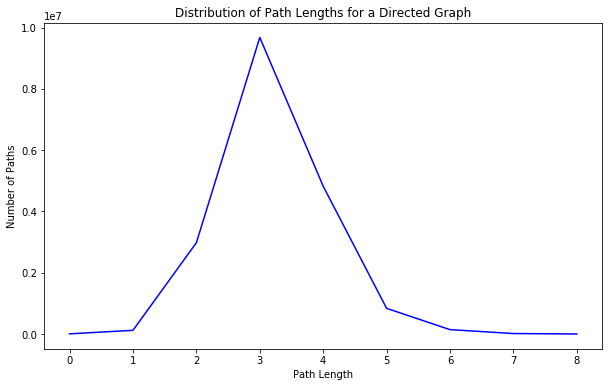

In [7]:
# create a list to hold all the path lengths retrieved from the wikispediagraph
all_path_lengths = []

# path_lengths is a dict containing another dict
#networkx: path[source][target]=L, L - the length of the shortest path
for source, targets in path_lengths.iteritems():
    # get a list of all path lengths
    l = targets.values()
    all_path_lengths.extend(l)

#Distributions
min_length = min(all_path_lengths)
max_length = max(all_path_lengths)

bins = [num for num in range(min_length,max_length+1)]
hist, bin_edges = np.histogram(all_path_lengths, bins)

plt.figure(figsize=(10,6))
plt.plot(bin_edges[:-1], hist, 'b-')
plt.title('Distribution of Path Lengths for a Directed Graph')
plt.ylabel("Number of Paths")
plt.xlabel("Path Length")
plt.show()

**For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths.**

In [8]:
#Fist for holding all lengths of human path
human_path_lengths_dict = {}

f = io.open('files/wikigame/paths_finished.tsv', 'r', encoding='utf-8')

#Split on tabs
for line in f:
    table = line.split()
    
    #don't include comments
    if '#' in table or not table:
        continue
    # the 4th column contains the path
    path = table[3]
    
    # nodes are semi-colon delimited
    nodes = path.split(';')
    
    source = urllib.unquote(str(nodes[0])).decode('utf8')
    target = urllib.unquote(str(nodes[-1])).decode('utf8')
    
    # solving problem when the game is finished or errors being caused when dealing with GNU License
    if source == target or 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' in nodes:
        continue
        
    # length is equal to the total number of nodes found minus all the backspaces
    length = len(nodes) - nodes.count('<')
    
    # path[source][target] = length
    if source in human_path_lengths_dict:
        if target in human_path_lengths_dict[source]:
            human_path_lengths_dict[source][target].append(length)
        else:
            human_path_lengths_dict[source][target] = [length]
    else:
        human_path_lengths_dict[source] = {target: [length]}
    
# close file
f.close()

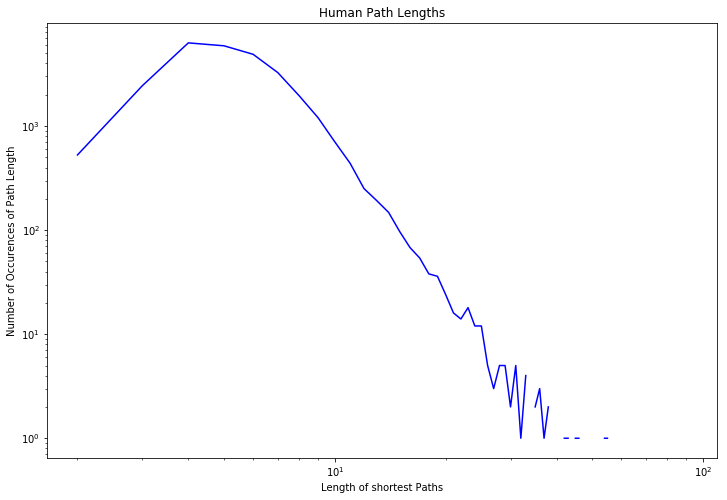

In [9]:
# Create list that contains all of the average lengths for each source/target pair
all_human_lengths_values = [np.average(lengths) for source, targets in human_path_lengths_dict.iteritems() for target, lengths in targets.iteritems()]

# create distributions, use min and max to create bins
min_length = int(min(all_human_lengths_values))
max_length = int(max(all_human_lengths_values))

bins = [num for num in range(min_length,max_length+1)]
hist, bin_edges = np.histogram(all_human_lengths_values, bins)

plt.figure(figsize=(12,8))
plt.loglog(bin_edges[:-1], hist, 'b-')
plt.title('Human Path Lengths')
plt.ylabel("Number of Occurences of Path Length")
plt.xlabel("Length of shortest Paths")
plt.show()

**How much longer are the human paths on average?**

In [10]:
average_path = np.average(all_path_lengths)
average_human_path = np.average(all_human_lengths_values)

diference = average_human_path - average_path

print "Human paths are on average %f nodes longer than the shortest path" % diference

Human paths are on average 2.815613 nodes longer than the shortest path


**Create scatter plot where each point is a source/target pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.**

In [11]:
#Create the empty lists for y and z axis
y = []  #for shortest path
x = []  # for human path lengths

for human_source, human_targets in human_path_lengths_dict.iteritems():
    
    #check if source is in path lengths
    if human_source not in path_lengths:
        continue
        
    for human_target, human_lengths in human_targets.iteritems():
        human_length = np.average(human_lengths)
        x.append(human_length)
        
        path_length = path_lengths[human_source][human_target]
        y.append(path_length)

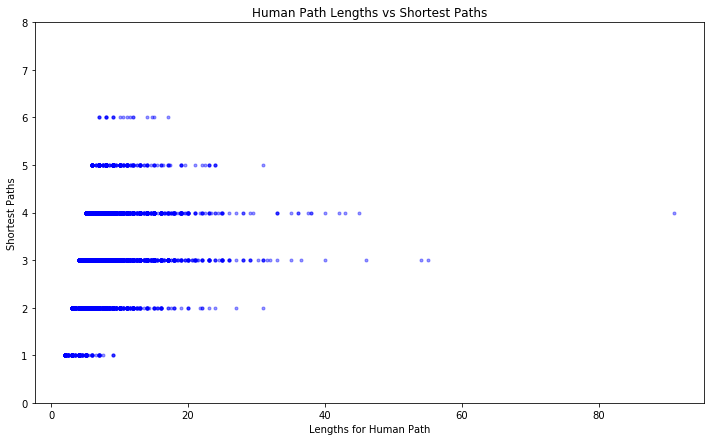

In [12]:
#Create scatter plot
plt.figure(figsize=(12,7))
plt.plot(x,y, 'b.', alpha=0.4)
plt.title("Human Path Lengths vs Shortest Paths")
plt.xlabel("Lengths for Human Path")
plt.ylabel("Shortest Paths")
plt.ylim(0,8)
plt.show()

**Is there a correlation between human/shortest path-lengths? What is the correlation.
**

<span style="color:blue">We can't observe any clear correlation between human and shortest path lengths. We can just assume that humans have a problem to find the shortest path, since where the shortest path increase by 1, human path is between higher range. This correlation is not linear.</span>


## IIb Betweenness


**Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset. 
**

In [13]:
G = wikispeedia_graph
# Calculate betweeness centrality
between_centrality = nx.betweenness_centrality(G)

**Calculate navigation centrality**

In [16]:
# All shortest path
shortest_path_links = nx.shortest_path(G)
navigation_path_size = 0

navigation_centrality = {}
#Each node starts with navigtion_centrality equal 0
for node in nx.nodes(G):
    navigation_centrality[node] = 0

#Incrementing count for current node    
for source, targets in shortest_path_links.iteritems():
    for target, path in targets.iteritems():
        navigation_path_size += 1
        for node in path[1:-1]:
            navigation_centrality[node] +=1

In [17]:
for node, centrality in navigation_centrality.iteritems():
    navigation_centrality[node] /= navigation_path_size

**First, list the 5 pages with highest navigation centrality.
**

In [18]:
#Sorting navigation centrality
navigation_centrality_sorted = sorted(navigation_centrality.iteritems(), key=lambda (k,v): -v)

print "Top 5 pages with the highest Navigation Centrality:"
for item in navigation_centrality_sorted[:5]:
    print "The page %s has navigation centrality equal %0.4f" % item

Top 5 pages with the highest Navigation Centrality:
The page United_States has navigation centrality equal 0.0980
The page United_Kingdom has navigation centrality equal 0.0544
The page Europe has navigation centrality equal 0.0361
The page England has navigation centrality equal 0.0319
The page Canada has navigation centrality equal 0.0224


**Second, list the 5 pages with highest betweenness centrality.**

In [19]:
#Sorting betweenness centrality
betweenes_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (k,v): -v)

print "Top 5 pages with the highest Betweennes Centrality:"
for item in betweenes_centrality_sorted[:5]:
    print "The page %s has a betweenness centrality equal %0.4f" % item

Top 5 pages with the highest Betweennes Centrality:
The page United_States has a betweenness centrality equal 0.0941
The page United_Kingdom has a betweenness centrality equal 0.0424
The page England has a betweenness centrality equal 0.0324
The page Europe has a betweenness centrality equal 0.0270
The page Africa has a betweenness centrality equal 0.0242


**Compare the two lists. Explain the differences between the two lists in your own words.
**

<span style="color:blue">The top 5 pages are the same on two lists, however we can observe that navigation centrality, in majority of printed articles, tends to be higher than betweenness centrality.</span>

**Create a scatterplot of betweenness centrality vs. navigation centrality.
**

In [20]:
#Create the empty lists for y and z axis
navigation_centralities = []  # y axis
between_centralities = []  # x axis

for node, bw_centrality in between_centrality.iteritems():
    between_centralities.append(bw_centrality)
    navigation_centralities.append(navigation_centrality[node])

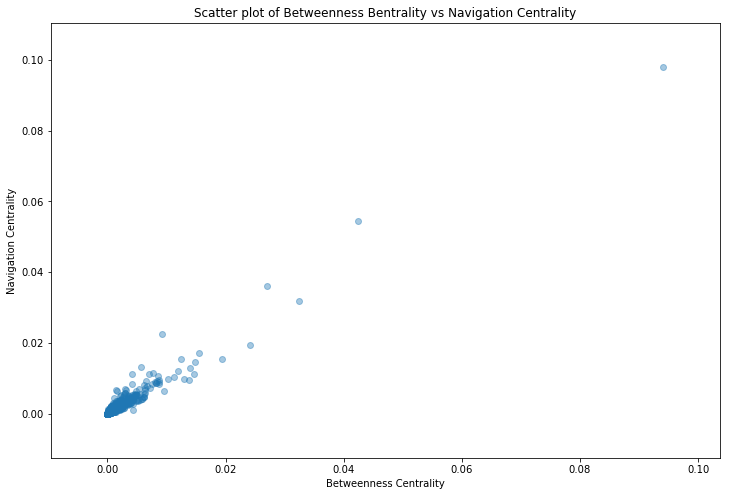

In [21]:
#Create a scatterplot
plt.figure(figsize=(12,8))
plt.scatter(between_centralities, navigation_centralities, alpha=0.4)
plt.title('Scatter plot of Betweenness Bentrality vs Navigation Centrality')
plt.ylabel("Navigation Centrality")
plt.xlabel("Betweenness Centrality")
plt.show()

**Let's explore the pages that have navigation centrality equal to zero. How many pages have zero navigation centrality?
**

In [22]:
navigation_with_zero = [node for node, value in navigation_centrality.iteritems() if value == 0 ]

print "%s pages have navigation centrality equal to zero" % len(navigation_with_zero)

569 pages have navigation centrality equal to zero


**What is the the page with zero navigation centrality and highest betweenness centrality?**

In [23]:
#Starting with highest betweenness centrality equal to 0
highest_between_centrality = 0
page_zero_highest = '' # page with highest betweenness centrality and zero nav centrality

In [24]:
for page in navigation_with_zero:
    this_page_btw_centrality = between_centrality[page]
    if this_page_btw_centrality >= highest_between_centrality:
        highest_between_centrality = this_page_btw_centrality
        page_zero_highest = page

In [25]:
print "The page with zero navgation centrality and the highest betweenness centrality is %s with %f betweenness centrality" % (page_zero_highest, highest_between_centrality )

The page with zero navgation centrality and the highest betweenness centrality is Brabantian with 0.000009 betweenness centrality


**Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).**

In [26]:
page_degree = G.degree(page_zero_highest)
print "The page %s has degree of %s" %(page_zero_highest, page_degree)

The page Brabantian has degree of 14


In [27]:
degree_average = np.average([G.degree(node) for node in G.nodes()])
print "The average degree in this network is %s" % degree_average

The average degree in this network is 52.2134146341


<span style="color:blue">This page has 14 connections to other nodes(pages), since the average degree in this netwrok is 52, and we need to remeber that this particular page has zero navigation centrality, we can say that page Brabantian is central.</span>

**Plot the distribution of betweenness centrality for the pages with zero navigation centrality.**

In [28]:
nav_pages_zero_values = map(lambda k: between_centrality[k], navigation_with_zero)

nav_pages_zero_hist, nav_pages_zero_bin = np.histogram(nav_pages_zero_values)

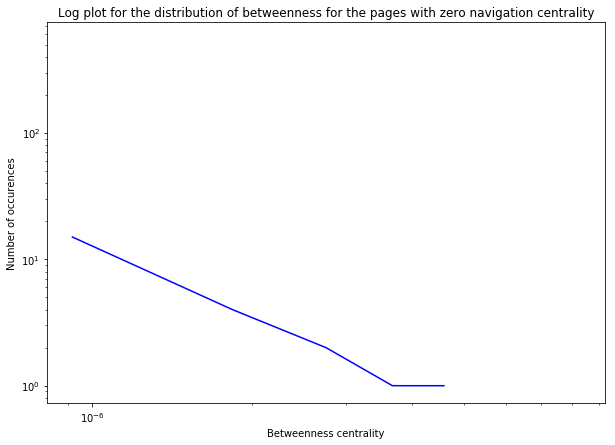

In [29]:
plt.figure(figsize=(10,7))
plt.loglog(nav_pages_zero_bin[:-1], nav_pages_zero_hist, 'b')
plt.xlabel('Betweenness centrality')
plt.ylabel('Number of occurences')
plt.title('Log plot for the distribution of betweenness for the pages with zero navigation centrality')

**Now, let's throw out all pages with zero navigation centrality and compare navigation- and betweenness centrality for the remaining pages.**

In [30]:
not_zero_nav_centrality = []
not_zero_bw_centrality =[]

for node, centrality in navigation_centrality.iteritems():
    if node not in navigation_with_zero:
        not_zero_nav_centrality.append(centrality)
        not_zero_bw_centrality.append(between_centrality[node])       

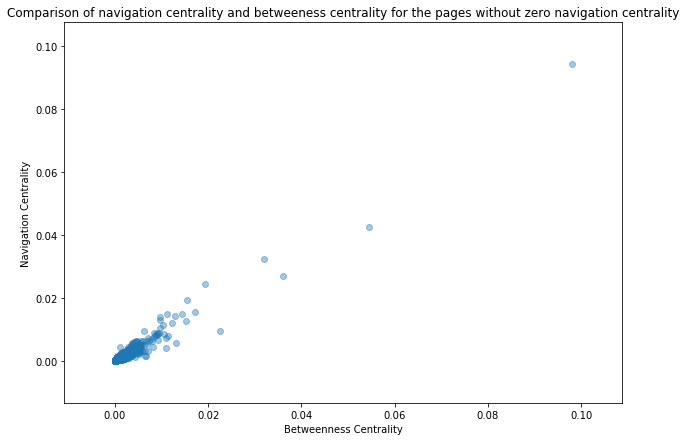

In [31]:
plt.figure(figsize=(10,7))
plt.scatter(not_zero_nav_centrality, not_zero_bw_centrality, alpha=0.4)
plt.title("Comparison of navigation centrality and betweeness centrality for the pages without zero navigation centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Navigation Centrality")

**What is the correlation between betweenness centrality and navigation centrality?**

In order to see this correlation, we are assuming that there is linear correlation and we have used linear regression and then made plotting the regression line on existing the scatter plot.

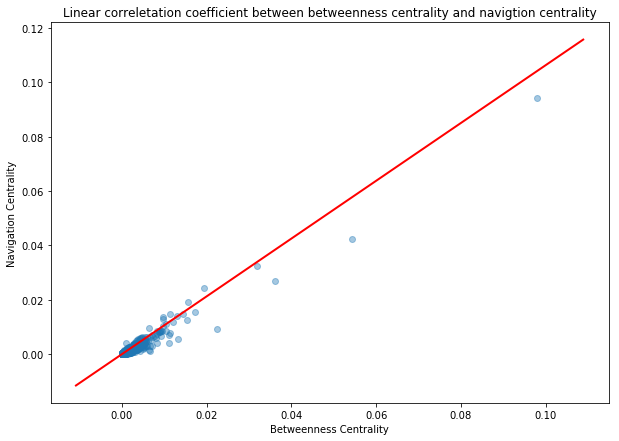

In [32]:
from scipy import stats

#Linear regression
slope, intercept, r_value, p_value, stand_error = stats.linregress(not_zero_bw_centrality, not_zero_nav_centrality)

#Show the orginal scatter plot from previous step
plt.figure(figsize=(10,7))
plt.scatter(not_zero_nav_centrality, not_zero_bw_centrality, alpha=0.4)
plt.title("Linear correletation coefficient between betweenness centrality and navigtion centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Navigation Centrality")

#Plotting linear regression on the existing scatter plot
axis = plt.gca()
x_axis = np.linspace(axis.get_xlim()[0], axis.get_xlim()[1])
#Make the linear line
y_axis = intercept + x_axis * slope

plt.plot(x_axis, y_axis, color="red", linewidth = 2)
plt.show()

In [33]:
print "We can observe a linear correlation bewteen the navigation and betweenness centrality, with %f correlation coefficient." % r_value 

We can observe a linear correlation bewteen the navigation and betweenness centrality, with 0.975945 correlation coefficient.


**Comment on the top 5 outliers.**

In [34]:
page_centrality_non_zero = []

for node, centrality in navigation_centrality.iteritems():
    if node not in navigation_with_zero:
        page_centrality_non_zero.append((node, (centrality, between_centrality[node])))
n = 20
# Sorting by descending betweenness centrality (high x) and only keep the top n 
high_bw_pages = sorted(page_centrality_non_zero, key=lambda (node, (nav, bw)): -bw)[:n]
# Sorting by acending navigation centrality 
high_bw_low_nav_pages = sorted(high_bw_pages, key=lambda (node, (nav, bw)): nav)

print "Top 5 outliers:" 
for (node, (nav, bw)) in high_bw_low_nav_pages[:5]:
    print "%s -> nav: %f / betweenness centrality: %f" % (node, nav, bw)

Top 5 outliers:
Russia -> nav: 0.006329 / betweenness centrality: 0.009509
Human -> nav: 0.008387 / betweenness centrality: 0.008689
Asia -> nav: 0.008960 / betweenness centrality: 0.008728
Earth -> nav: 0.009636 / betweenness centrality: 0.013850
Japan -> nav: 0.009658 / betweenness centrality: 0.012973


<span style="color:blue">The 5 top outlners are names of countires. They appears here, becasue in Wikipedia listed pages have a lot of links. Maybe those pages are too general and too popular so player doesn't see it as a chance for the progress in the game.</span>

## IIc: Bringing the text into the picture


### H1: Human navigation paths have more similar content than newtwork shortest path


**First, create a TF-IDF vector for each page based on the ascii version of the page texts.**

In [35]:
# Getting tokens from text, using the function
def get_tokens(raw):
    tokens = nltk.word_tokenize(raw)
    stop_words = nltk.corpus.stopwords.words('english')
    
    words = [word for word in set(tokens) if word not in stop_words and word.isalpha()]
    return words

In [37]:
tokens = {}
directory = 'files/plaintext_articles'

try:
    print("Openning saved file")
    with open('tokens.pickle', 'rb') as pickled_f:
        tokens = pickle.load(pickled_f)
        pickled_f.close()
        
#Exception: If the file doenst exist, create the new one and save it        
except Exception as ex:
    print ("Creating dictionary")
    for filename in os.listdir(directory):
        f = io.open(directory + '/' + filename, encoding='utf-8')
        raw = f.read()
        name = urllib.unquote(str(filename.replace('.txt', ''))).decode('utf8')
    
        tokens[name] = get_tokens(raw)
        f.close()
        
#saving tokens    
    with open('tokens.pickle', 'wb') as pickled_f:
        pickle.dump(tokens, pickled_f, pickle.HIGHEST_PROTOCOL)
        pickled_f.close()

Openning saved file
Creating dictionary


In [38]:
#Creating dictionary of term frequencies for each word in article
dict_for_frequency = {}

for name, words in tokens.iteritems():
    freq_dist = nltk.FreqDist(words)
    dict_for_frequency[name] = dict(freq_dist.items())

In [39]:
dict_length = len(dict_for_frequency)
print dict_length

4604


In [41]:
test_key = dict_for_frequency.keys()[0]
print test_key
#print dict_for_frequency[test_key]

Hopman_Cup


In [42]:
print "The lenght of dictionary with frequency distribition for each article is %d" % dict_length

The lenght of dictionary with frequency distribition for each article is 4604


**Create dictionary for IDF values for words in all articles**

In [45]:
idf = {}
all_words = []

for name, words in tokens.iteritems():
    all_words.extend(set(words))

words_unique = set(all_words)
occurences = dict.fromkeys(words_unique, 0.)

# Total number of files 
N = len(tokens.keys())

for word in all_words:
    occurences[word] += 1.

for word, occurence in occurences.iteritems():
    idf[word] = math.log(N/occurence, 10)

In [46]:
print "The length of idf is %d" % len(idf)

The length of idf is 261039


In [47]:
test_key= idf.keys()[0]
print test_key
print idf[test_key]

Alys
3.18601406024


**Create a dictionary TF-IDF values that saves idf for each article**

In [48]:
tf_idf = {}
# Take words for each article
for name, words in tokens.iteritems():
    tf_idf[name] = {}
    
    for word in words:
        tf_idf[name][word] = dict_for_frequency[name][word] * idf[word]        

In [49]:
print "Show example keys:"
print tf_idf.keys()[:3] #Checking the keys

Show example keys:
[u'Hopman_Cup', u'Thomas_Cranmer', u'Novelty_(locomotive)']


In [50]:
#Checking TF-IDF dictionary for Hopman_Cup
print tf_idf['Hopman_Cup'].items()[:5]

[(u'coach', 1.5328015464627478), (u'played', 0.6436036304264987), (u'sanctioned', 1.799812454837298), (u'Prpic', 3.6631353149577537), (u'Hantuchov\xe1', 3.362105319293773)]


**Write a function that calculates the distance between a pair of vectors**

We define Cosine Similarity that will be used later:

In [ ]:
def cosine_similarity(A,B):
    dot = 0.
    
    #To reduce iterations, set A to the smaller
    if len(B) < len(A):
        A, B = B, A
    
    for word, value in A.iteritems():
        dot += value * B.get(word,0)
    
    # compute the cosine similarity 
    return dot / (np.linalg.norm(A.values()) * np.linalg.norm(B.values()))

**Calculate the average pairwise similarity for all human navigation paths (the source/target pairs from above). With start and end at node $i,j$ we can call this similarity $s_{i,j}$. Calculate mean/variance of the $s_{ij}$'s.
 **

Creating a function that will return list containing the similarities of a path. We are using it later for human and shortes paths

In [77]:
def count_path_similarity(tf_idf, path):
 
    path_similarities = []
    
    #similarity between each neighboring node
    for ii in xrange(0, len(path)-1):
        #two nodes that are neighbors
        node1, node2 = path[ii], path[ii+1]

        A, B = tf_idf[node1], tf_idf[node2]
        # Similarity between the two vectors
        cos_sim = cosine_similarity(A,B)
        
        # saving to list
        path_similarities.append(cos_sim)
        
    return path_similarities

First we need to create dictionaries for all human paths

In [78]:
# create list to hold all lengths
all_human_paths = {}

f = io.open('files/wikigame/paths_finished.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    table = line.split()
    
    # skip all comments at the top of the file
    if '#' in table or not table:
        continue
    
    path = table[3]  # In 4th column given path
    nodes = [urllib.unquote(str(node)).decode('utf8') for node in path.split(';')]
    source = nodes[0]
    target = nodes[-1]
    
    # check if the game is already over with source == target and dealing with GNU License
    if source == target or 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' in nodes:
        continue
    
    ### TRIM BACKSPACED PAGES FROM PATH ###
    backspace = '<'
    while backspace in nodes:
        idx_backspace = nodes.index(backspace)
        # remove back space character from path
        del nodes[idx_backspace]
      
    
    # path[source][target] = a list of list containing nodes in path
    if source in all_human_paths:
        if target in all_human_paths[source]:
            all_human_paths[source][target].append(nodes)
        else:
            all_human_paths[source][target] = [nodes]
    else:
        all_human_paths[source] = {target: [nodes]}
    
f.close()

**Human Similarities**

In [82]:
human_similarities = {}
human_similarities_list = []

# iterate through all human paths
for source, targets in all_human_paths.iteritems(): 
    
    human_similarities[source] = {}
    
    # calculate the cosine similarity for each target
    for target, paths in targets.iteritems():
        
        #average value of each path
        average_similarities = []
        for path in paths:
            # only consider paths greater then 2
            if len(path) > 2:
                path_similarities = count_path_similarity(tf_idf, path)
                average_similarities.append(np.average(path_similarities))
        
        # the average similarity
        if average_similarities:
            average_similarity = np.average(average_similarities)
            human_similarities_list.append(average_similarity)
            human_similarities[source][target] = average_similarity

In [90]:
print "Human Paths:"
print "Mean: %f" % np.nanmean(human_similarities_list)
print "Variance: %f" % np.nanvar(human_similarities_list)

Human Paths:
Mean: 0.084020
Variance: 0.000883


**Calculate the average pairwise similarity for all shortest paths between the source/target pairs ($S_{i,j}$). Calculate mean/variance of the $S_{i,j}$.**

**Shortest Path Similarities**

In [91]:
shortest_path_similarities_list = []
shortest_path_similarities = {}

# iterate through source/target pairs from the human paths
for source, targets in all_human_paths.iteritems(): 
    
    shortest_path_similarities[source] = {}
    
    # the cosine similarity for each target
    for target in targets.keys():
        
        # finding the path 
        path = nx.shortest_path(G, source=source, target=target)
        
        # ignore all paths containing only a source and target node
        if len(path) > 2:
            path_similarities = count_path_similarity(tf_idf, path)

            average_similarity = np.average(path_similarities)
            shortest_path_similarities[source][target] = average_similarity
            shortest_path_similarities_list.append(average_similarity)

In [92]:
print "Shortest Paths:"
print "Mean: %f" % np.mean(shortest_path_similarities_list)
print "Variance: %f" % np.var(shortest_path_similarities_list)

Shortest Paths:
Mean: 0.063959
Variance: 0.000548


**Plot the distributions of average pairwise similarities for both human- and shortest paths in a single plot.**

In [97]:
binwidth = 0.02

plt.figure(figsize=(14,8))

bins =  np.arange(min(data), max(data) + binwidth, binwidth)
data1 = human_similarities

hist, bin_edges = np.histogram(data1, bins=bins)
plt.plot(bin_edges[:-1], hist, 'b-')

data2 = shortest_path_similarities
hist, bin_edges = np.histogram(data2, bins= bins)
plt.plot(bin_edges[:-1], hist, 'g-')

plt.ylabel("Number of Occurences")
plt.xlabel("Average Cosine Similarity of TF-IDF")
plt.xlim(0,0.45)
plt.show()

TypeError: unsupported operand type(s) for +: 'dict' and 'float'

**Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.**

In [100]:
count =0.
lower = 0.

# iterate through human paths
for source, targets in human_similarities.iteritems(): 
    
    if nonhuman_similarities.get(source) is None:
        continue
    # the cosine similarity for each target
    for target, paths in targets.iteritems():
        
        if shortest_path_similarities[source].get(target) is None:
            continue
        
        human = human_similarities[source][target]
        shortest_path = shortest_path_similarities[source][target]
        
        count += 1
        if shortest_path > human:
            lower += 1
            
result = lower / count            
            
print "Fraction of time human average similarity is lower: %s" % result

Fraction of time human average similarity is lower: 0.185874672693


**Comment on your findings. Is H1 true?**

<span style="color:blue">Human average similarity is only 18% lower than the shortest path similarity of the time. Thanks to that we can confirm our H1 , saying that human navigation paths tends to be more similar than shortest path. So when human are looking for some content/target they are more likely to go through (navigate) on similar pages.</span>

# Part III

**Exercise, sentiment over some books from NLPP1e**
* **Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.**

<span style="color:blue">The list consists of one word per line with different scores associated, the one that we are using is the second column, happiness average, which gives a sentiment score for each word </span>

* **Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached.**

In [10]:
# Create a sentiment dictionary to measure the happiness of the words
f = io.open("Data_Set_S1.txt",mode = 'r',encoding = "utf-8")
lines = f.readlines(); f.close()
del lines [:4]; sentiment_dict = {}
for ii in range(len(lines)):
    line = lines[ii].split()
    sentiment_dict[line[0]] = float(line[2])  

In [11]:
# Function to calculate the happiness of a set of words (tokens)
def sentimentAnalisys(tokens):   
    lyric_score = []
    for word in tokens:
        if word in sentiment_dict:
            lyric_score.append(sentiment_dict[word])
    if lyric_score: 
        return np.mean(lyric_score)
    else:
        print "There are no words with sentiment attached in the list"
        return 0.0

* **Calculate a sentiment profile for the novels in NLPP1e chapter 1. The sentiment profile has sentiment on the $y$-axis and position in the text on the $x$-axis. Use a moving average to show how the sentiment changes. Create profiles for sliding windows of length 50 words, 100 words, 500 words.**

There are no words with sentiment attached in the list


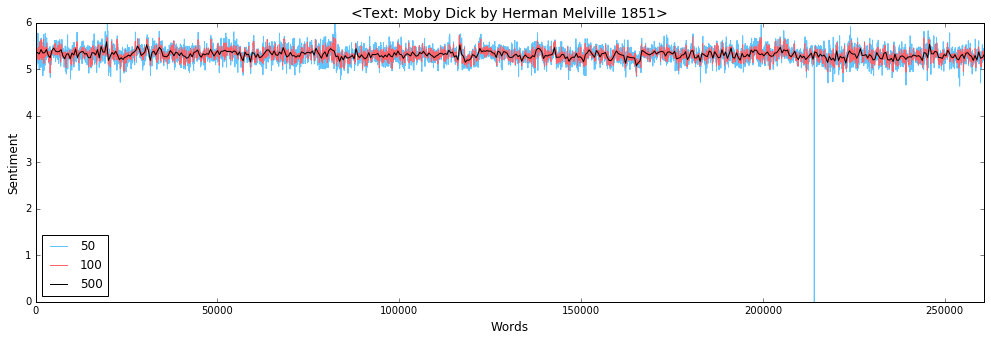

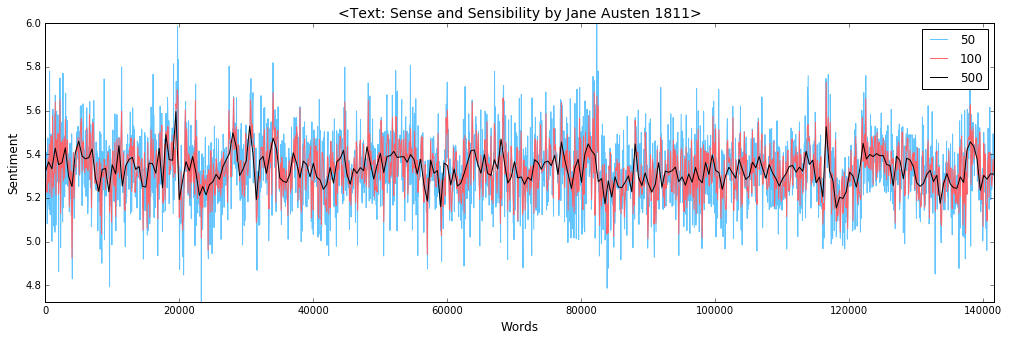

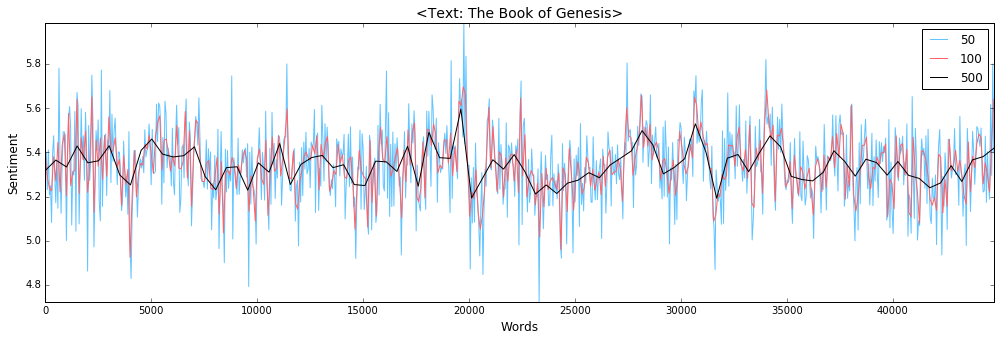

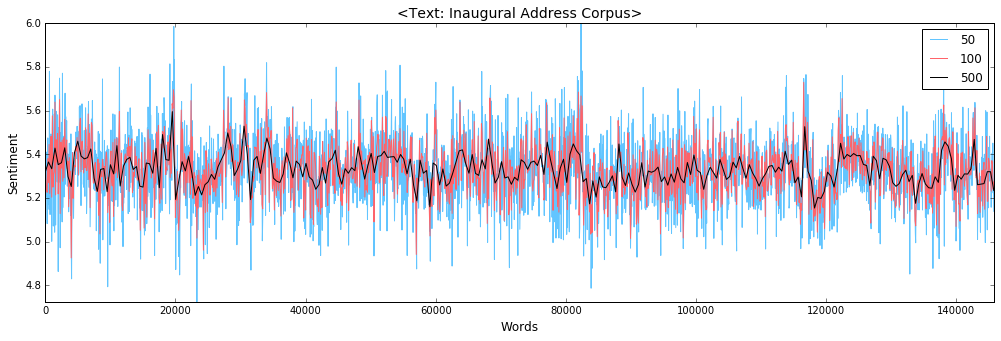

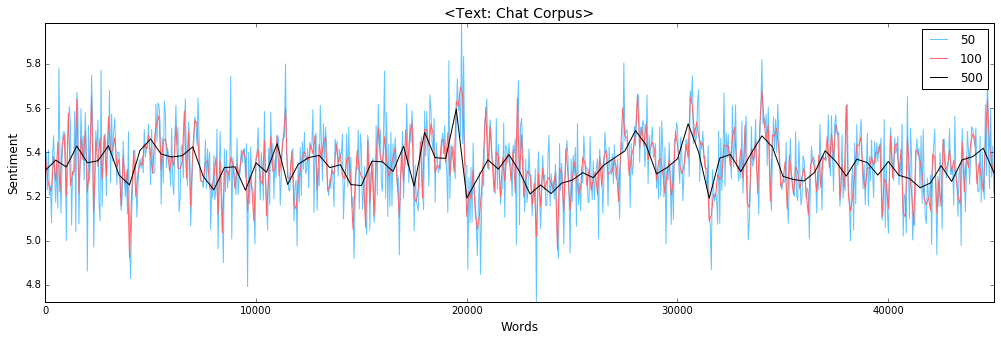

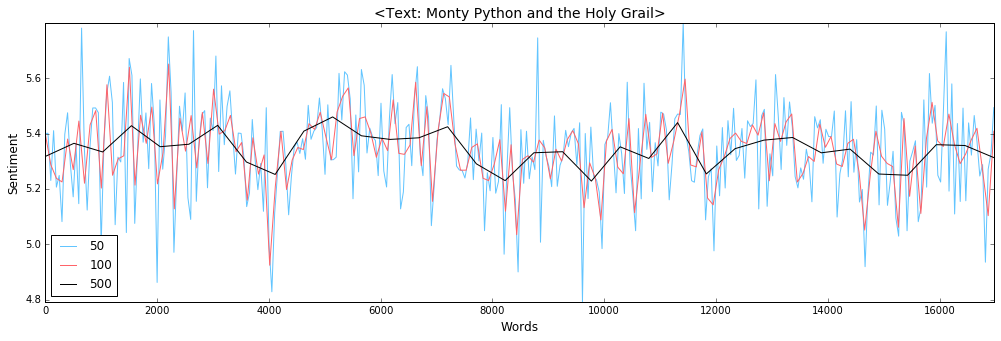

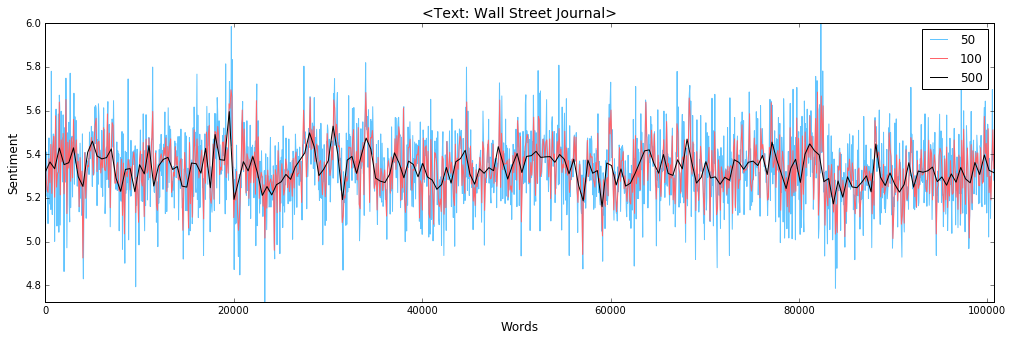

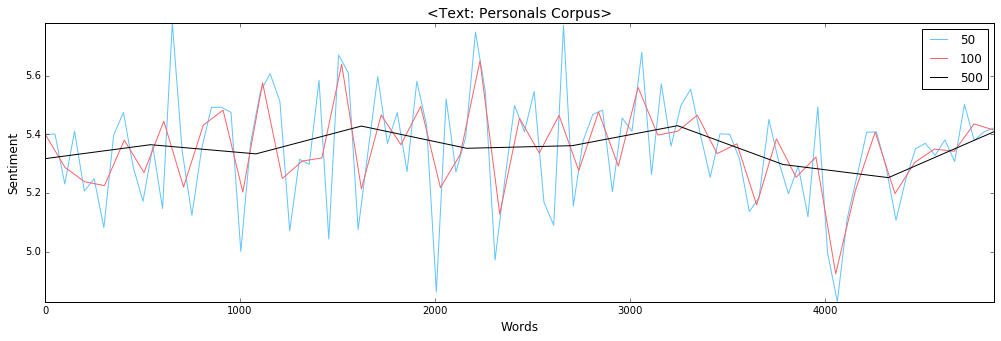

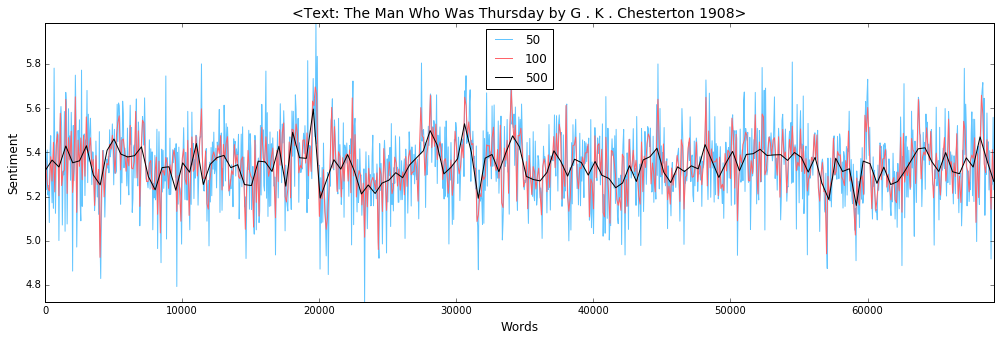

In [12]:
# List to iterate over all the texts
books = [text1,text2,text3,text4,text5,text6,text7,text8,text9]

# Different window sizes
window_len = [50,100,500]

for text in books:
    sentiment = []
    for window in window_len:
        aux = []
        
        # Calculate the sentiment for the set of words according to the each window size
        for ii in range(0,len(text),window):
            aux.append(sentimentAnalisys(text1[ii:ii+window]))  
        sentiment.append(aux)  
        
    # Resize result to plot them in a single figure    
    x = np.linspace(0, len(text), num=len(sentiment[0]), endpoint=True)
    y = sentiment[0]

    x2 = np.linspace(0, len(text), num=len(sentiment[1]), endpoint=True)
    f2 = interp1d(x2, sentiment[1], kind='cubic')

    x3 = np.linspace(0, len(text), num=len(sentiment[2]), endpoint=True)
    f3 = interp1d(x3, sentiment[2], kind='cubic')

    plt.figure(1, figsize=(17, 5))
    plt.plot(x,y,'#62c5ff',x2,f2(x2),'#ff6369',x3,f3(x3),'#000000')
    plt.legend(['50', '100', '500'], loc='best')
    plt.axis([0, len(text),min(sentiment[0]),max(sentiment[0])])
    plt.xlabel('Words',fontsize=12)
    plt.ylabel('Sentiment',fontsize=12)
    plt.title(text,fontsize=14)
    plt.show()

* **Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window?**

<span style="color:blue"> When the window is bigger the sentiment profile tends to be smoother. This is because when we use more words the result consist on the average and therefore changes between sections are smaller </span>